In [25]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import tqdm

from modules import *
input_data = InputData("ANSPRACHE_MARKETING_IMPUTED", max_twin_num = 10, kernel_size = 1) #Options: ANSPRACHE, ANSPRACHE_MARKETING_IMPUTED

There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 71 NaN values in the data which are replaced with 0s.
There are 154 NaN values in the data which are replaced with 0s.
There are 7 NaN values in the data which are replaced with 0s.
There are 21 NaN values in the data which are replaced with 0s.
There are 33 NaN values in the data which are replaced with 0s.
There are 6 NaN values in the data which are replaced with 0s.
There are 25 NaN values in the data which are replaced with 0s.
There are 191 NaN values in the data which are replaced with 0s.
There are 61 NaN values in the data which are r

In [26]:
# TODO: evaluieren der korrekten window positionen unter zero indexing, was sind die mindest dinger für die grid search windows, input dataen vollenden (z.B. NAs), die iid bootstraps implementieren
# alternativ den Mean Absolute Scaled Error und Symmetric Mean Absolute Percentage Error testen
#MASE: normieren des Fehlers mit mit mae eines naiven benchmarks

# FIXME: 

# NOTE: NA printout currently disabled for debugging, must be looked into later, evaluate why identical bounds from paper are not robust to all parameter combinations
#kann ich meine Ergebnisse eindeutiger machen, wenn ich mehr als 100 Testartikel nehme?
# Wie kann ich unterscheiden, ob der Fehler vom Model oder von den Twins kommt

#bias berechnung anders machen

# Window Size Analysis

[  0.   5.  13.  21.  29.  37.  45.  53.  61.  69.  77.  85.  93. 101.
 109. 117. 125. 133. 141. 149. 157. 165. 173. 181. 189. 197. 205. 213.
 221. 229. 237. 245. 253. 261. 269. 277. 285. 293. 301. 303.]
[  2.  10.  18.  26.  34.  42.  50.  58.  66.  74.  82.  90.  98. 106.
 114. 122. 130. 138. 146. 154. 162. 170. 178. 186. 194. 202. 210. 218.
 226. 234. 242. 250. 258. 266. 274. 282. 290. 298. 305. 305.]


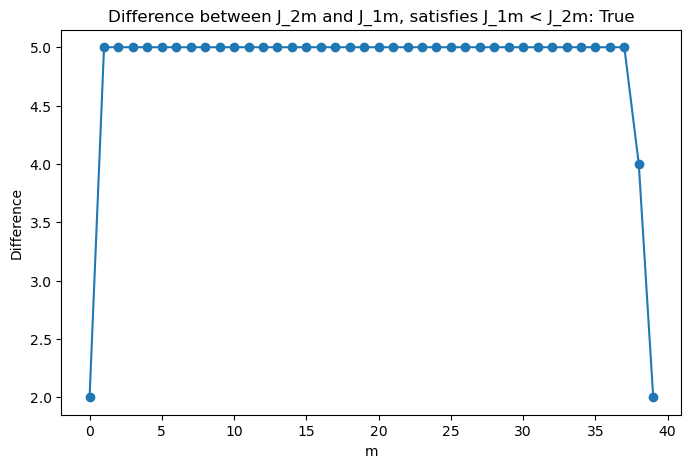

In [27]:
#sind meine windows centered oder asymmetrisch? -> den zenterpunkt +0.5 setzen
#window size dürfen nur gerade zahlen sein, sonst sind grenzen dezimalzahlen
#dadurch, dass der ub nicht inclusive ist, sind die intervalle nicht symmetrisch um den Index m*b
#was wäre eine Lösung? (abwägung zwischen symmetrischem, ungeraden intervall und asymmetrischem, geraden intervall)
#window size 1 hat die beste performance, dass müssen wir also eigentlich berücksichtigen
#-> wie verhalten sich die intervallgrenzen bei window size 1? mit den decimalzahlengrenzen
#-> vielleicht is es deshalb nicht viel besser als der standard bootstrap
N = 313
b = 8
w = 4
M = int(np.ceil(N / b))

# Compute J_1m and J_2m
J_1m_values = np.maximum(0, np.minimum(np.arange(M) * b - w/2-1, N-b - w/2))# Shape: (M,)
print(J_1m_values)
J_2m_values = np.maximum(0, np.minimum(np.arange(M) * b + w/2, N-b))    # Shape: (M,)
print(J_2m_values)

# Compute the difference
difference = J_2m_values - J_1m_values

# Plot the difference
plt.figure(figsize=(8, 5))
plt.plot(range(M), difference, marker='o', linestyle='-', label='J_2m - J_1m')
plt.xlabel('m')
plt.ylabel('Difference')
plt.title(f'Difference between J_2m and J_1m, satisfies J_1m < J_2m: {~np.any(J_1m_values >= J_2m_values)}')
plt.show()

# Empirical Test of Local Block Bootstrap

In [28]:
# input_validation = InputData("ANSPRACHE_MARKETING_IMPUTED", max_twin_num = 10, kernel_size = 15)
# input_validation.TwinData = input_validation.TestData

# Evaluation.run_grid(input_data, output_file="method_validation")

In [29]:
df_validation = pd.read_csv("results/method_validation.csv") #method_validation
df_validation.groupby(["WINDOW_SIZE", "BLOCK_SIZE"]).median().sort_values("WASSERSTEIN").reset_index().head(10) #median, bc distribution is skewed

,WINDOW_SIZE,BLOCK_SIZE,TEST_ITEM_COMMUNICATIONKEY,TWIN_NUMBER,MEAN_SAMPLE,MEAN_TEST,BIAS,RESAMPLING_VARIANCE,TARGET_VARIANCE,CV,RMSE,MAPE,MPE,MAE,WASSERSTEIN
0,0,1,851443376.0,6.5,403.939687,337.5,56.948031,3286.973297,7.300368e+05,0.132558,220.533214,0.616538,0.251817,210.132116,213.353621
1,13,1,851443376.0,6.5,404.100026,337.5,57.773689,2472.289038,7.031013e+05,0.118151,216.564327,0.614949,0.250510,209.066077,215.380785
2,5,1,851443376.0,6.5,403.291614,337.5,57.795734,2340.312242,7.086509e+05,0.114919,218.100838,0.610066,0.254887,210.899137,215.624753
3,9,1,851443376.0,6.5,404.440010,337.5,58.738711,2432.796768,7.035786e+05,0.116594,217.355853,0.606414,0.254018,210.339506,215.766049
4,57,7,851443376.0,6.5,407.309199,337.5,68.784894,12307.895764,1.143908e+06,0.237685,250.243462,0.656647,0.253254,219.448484,217.085097
5,33,1,851443376.0,6.5,406.794712,337.5,59.466356,2632.484146,6.851622e+05,0.119226,217.817285,0.620033,0.252013,211.890223,217.120773
6,17,1,851443376.0,6.5,403.194467,337.5,58.921058,2546.970155,7.053161e+05,0.118997,216.906758,0.613312,0.248587,210.036876,217.157387
7,1,1,851443376.0,6.5,402.586424,337.5,57.519657,2238.908276,7.105815e+05,0.111448,219.499892,0.613680,0.251833,212.876117,217.184372
8,21,1,851443376.0,6.5,404.626740,337.5,59.118228,2564.533283,7.010471e+05,0.118779,216.127913,0.619178,0.249895,210.288532,217.247533
9,41,1,851443376.0,6.5,406.352536,337.5,59.156723,2654.946453,6.907042e+05,0.120143,218.438686,0.623927,0.248699,205.977903,217.646442


# Parameter Tuning

In [30]:
Evaluation.run_grid(input_data)
df_grid_results = pd.read_csv("results/grid_results.csv")
df_grid_results.groupby(["WINDOW_SIZE", "BLOCK_SIZE"]).median().drop(["TEST_ITEM_COMMUNICATIONKEY", "TWIN_NUMBER"], axis=1).sort_values("MAE").reset_index().head(20) #median, bc distribution is skewed

Parameter Grid Search:   0%|          | 0/20 [00:00<?, ?it/s]

,WINDOW_SIZE,BLOCK_SIZE,MEAN_SAMPLE,MEAN_TEST,BIAS,RESAMPLING_MEAN_TWIN,RESAMPLING_MEAN_TEST,RESAMPLING_VARIANCE_TWIN,RESAMPLING_VARIANCE_TEST,TARGET_VARIANCE,CV,RMSE,MAPE,MPE,MAE,WASSERSTEIN
0,101,1,398.986428,337.5,58.268929,398.986428,341.713881,3022.876745,866.798481,2.214887e+06,0.122702,207.055806,0.637570,0.257065,185.706270,212.476581
1,105,1,399.198190,337.5,61.381175,399.198190,340.831888,3042.317442,873.701220,2.218460e+06,0.122610,206.613285,0.638090,0.258659,185.905712,210.137012
2,109,1,399.248911,337.5,62.223218,399.248911,340.235629,3064.611075,878.235255,2.219021e+06,0.123393,207.665892,0.635432,0.258203,186.756672,210.612974
3,97,1,399.348686,337.5,58.081092,399.348686,341.717278,2955.103930,847.933761,2.190246e+06,0.122779,207.599120,0.640208,0.255563,186.773622,213.430742
4,93,1,399.832512,337.5,57.775759,399.832512,342.567028,2944.341963,842.539449,2.178088e+06,0.122705,207.527325,0.641318,0.254962,187.796611,213.933755
5,89,1,399.921500,337.5,59.093700,399.921500,343.229002,2910.853041,825.569152,2.160918e+06,0.122391,209.411909,0.642844,0.256946,188.394027,215.179819
6,113,1,400.391721,337.5,63.896229,400.391721,339.643689,3031.086508,882.975170,2.263838e+06,0.122853,209.111665,0.635018,0.256548,189.865399,210.113303
7,85,1,401.724468,337.5,61.244242,401.724468,343.865584,2863.768983,816.466516,2.146021e+06,0.122161,211.199149,0.644517,0.255480,190.148795,215.679858
8,117,1,400.556765,337.5,63.562011,400.556765,339.069117,3057.705284,899.635997,2.302982e+06,0.123064,210.904582,0.633974,0.257643,190.728525,209.775940
9,81,1,401.919137,337.5,65.686449,401.919137,344.493653,2864.871617,816.713163,2.149000e+06,0.122306,213.899137,0.643250,0.254566,192.409495,214.901978


# Trends in Parameter Configuration

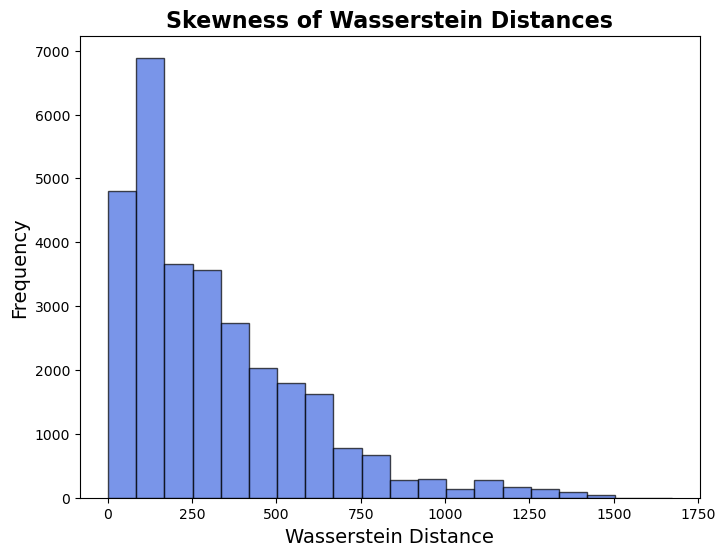

In [31]:
plt.figure(figsize=(8, 6))
plt.hist(df_grid_results.query("WINDOW_SIZE != 0")["WASSERSTEIN"], bins=20, color="royalblue", edgecolor="black", alpha=0.7)

# Labels and title
plt.xlabel("Wasserstein Distance", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Skewness of Wasserstein Distances", fontsize=16, fontweight="bold")

# Show the plot
plt.show()


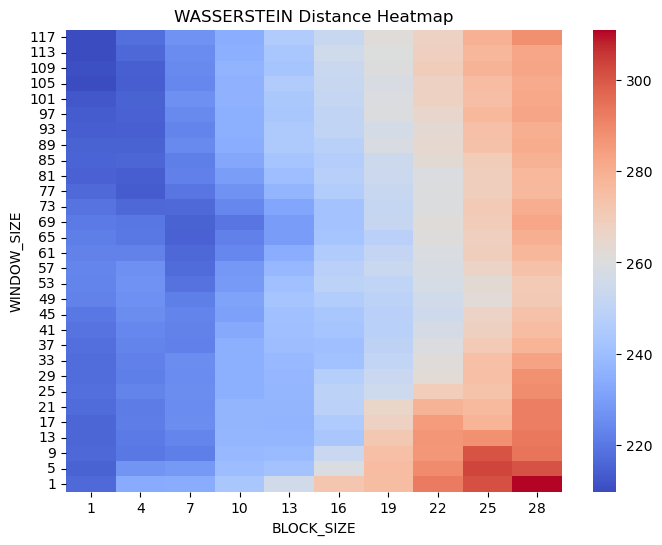

In [32]:
metric = "WASSERSTEIN"
df_heatmap = df_grid_results.query("WINDOW_SIZE != 0")\
    .groupby(["WINDOW_SIZE", "BLOCK_SIZE"]).median().reset_index()\
    .pivot(index="WINDOW_SIZE", columns="BLOCK_SIZE", values=metric).sort_index(ascending=False)

plt.figure(figsize=(8, 6))
sns.heatmap(df_heatmap.sort_index(ascending=False), cmap="coolwarm")#gray
plt.xlabel("BLOCK_SIZE")
plt.ylabel("WINDOW_SIZE")
plt.title(f"{metric} Distance Heatmap")
plt.show()

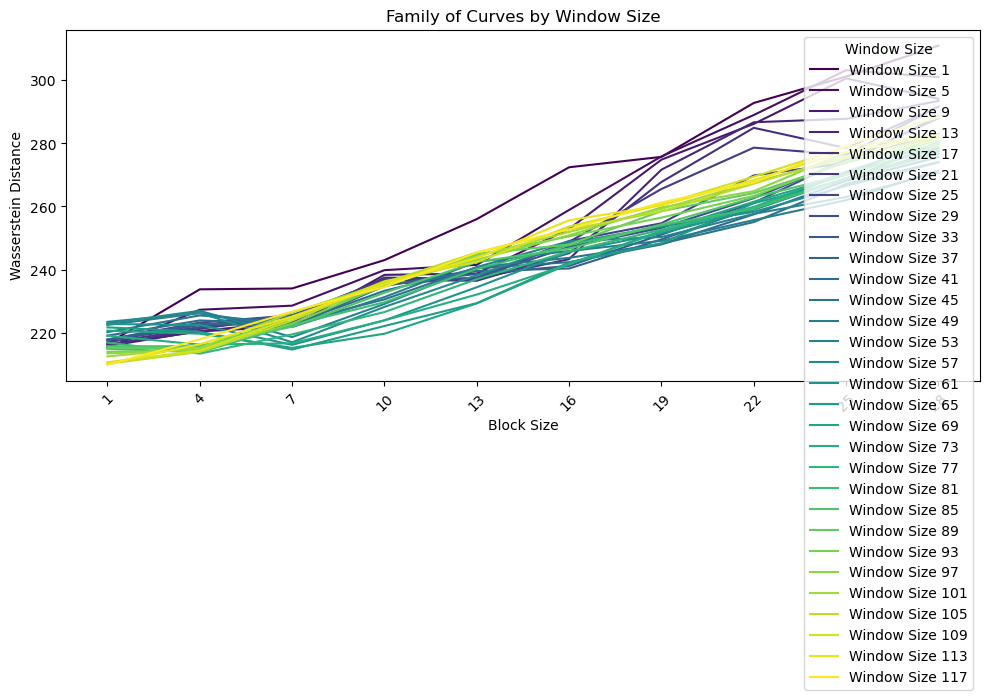

In [33]:
df_curve_array = df_grid_results.query("WINDOW_SIZE != 0").groupby(["WINDOW_SIZE", "BLOCK_SIZE"]).median().sort_values("WASSERSTEIN").reset_index().pivot(index = "WINDOW_SIZE", columns = "BLOCK_SIZE", values = "WASSERSTEIN")
# Assuming df_curve_array is already defined and pivoted as described
unique_window_sizes = df_curve_array.index.sort_values()
num_curves = len(unique_window_sizes)

# Create a color map to assign a color to each curve based on its index
cmap = plt.get_cmap("viridis")
colors = cmap(np.linspace(0, 1, num_curves))

plt.figure(figsize=(10, 6))

# Loop through each row (each window size becomes a curve)
for i, window_size in enumerate(unique_window_sizes):
    # x-axis: the BLOCK_SIZE values (assumed to be integers)
    x = df_curve_array.columns.astype(int)
    # y-axis: the Wasserstein values for the current window size
    y = df_curve_array.loc[window_size]
    plt.plot(x, y, label=f"Window Size {window_size}", color=colors[i])

plt.xlabel("Block Size")
plt.ylabel("Wasserstein Distance")
plt.title("Family of Curves by Window Size")
plt.legend(title="Window Size")

# Set an x-tick for every datapoint
x_ticks = df_curve_array.columns.astype(int)
plt.xticks(ticks=x_ticks, labels=x_ticks, rotation=45)

plt.tight_layout()
plt.show()

- keine wirklich neue Erkenntnis dadurch, dass man jetzt die Sprünge besser visualisiert hat imo

### Fazit
- im BIAS ist keine Struktur auf Grund verschiedener Parameter zu erkennen
- in der VARIANCE ist die Struktur deutlich
- Haupteinfluss in der Wasserstein Evaluierung ist die Varianz    
-> ist der Moving Bootstrap trotzdem noch besser, als der  IID Bootstrap (Vergleich von BIAS und Varianz)
- da wir BIAS und Variance als entscheidende Größen betrachten bewerten wir insgesamt mit der Wasserstein Metric, da sie sich decomposen lässt in BIAS und Variance Delta -> dafür muss normalität noch geprüft werden
- muss ich rechtfertigen, dass ich kein validation set habe?

# Best Local Parameters

In [34]:
#Idea to optimize the results by using subclusters in seperate python file
#Discarded as it seems to overengineer the problem in relation to the possible gain

input_data.TestData.keys()
df_grid_results.query("TEST_ITEM_COMMUNICATIONKEY == 807444058").sort_values("WASSERSTEIN")
#Order by Wasserstein
#Benchmark best: 716679764
#Random: 796628327, 803603891, 807444298, 811224241, 
#Moving Bootstrap best: 807443786

,TEST_ITEM_COMMUNICATIONKEY,BLOCK_SIZE,WINDOW_SIZE,TWIN_NUMBER,MEAN_SAMPLE,MEAN_TEST,BIAS,RESAMPLING_MEAN_TWIN,RESAMPLING_MEAN_TEST,RESAMPLING_VARIANCE_TWIN,RESAMPLING_VARIANCE_TEST,TARGET_VARIANCE,CV,RMSE,MAPE,MPE,MAE,WASSERSTEIN
3045,807444058,1,29,5,198.787047,246.0,-47.212953,198.787047,245.988796,585.962996,332.610427,226330.800024,0.121772,53.056818,0.194745,-0.191923,47.907302,47.583678
3055,807444058,1,37,5,199.013179,246.0,-46.986821,199.013179,246.302009,583.669397,340.140989,224433.709600,0.121395,52.833992,0.193673,-0.191003,47.643664,47.636787
3040,807444058,1,25,5,198.657321,246.0,-47.342679,198.657321,246.062418,565.806800,335.123686,225696.537682,0.119737,52.982413,0.194870,-0.192450,47.938104,47.726653
3050,807444058,1,33,5,198.557507,246.0,-47.442493,198.557507,246.085012,573.583197,337.799356,227082.414876,0.120618,53.144834,0.195377,-0.192856,48.062853,47.856582
3035,807444058,1,21,5,198.365729,246.0,-47.634271,198.365729,245.956601,571.194891,329.373647,228356.419689,0.120483,53.293702,0.196202,-0.193635,48.265762,47.944120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4375,807444058,28,13,5,199.041780,246.0,-46.958220,199.041780,248.688749,6833.292203,63.995365,726668.507887,0.415308,95.070325,0.325539,-0.190887,80.082655,89.709351
4210,807444058,25,1,5,199.313875,246.0,-46.686125,199.313875,247.974816,6033.409003,2.857183,660311.652329,0.389712,90.625621,0.308258,-0.189781,75.831350,90.281122
4370,807444058,28,9,5,197.957787,246.0,-48.042213,197.957787,249.590681,6837.501895,51.249500,735286.739373,0.417711,95.632401,0.329123,-0.195294,80.964348,91.543427
4365,807444058,28,5,5,197.587880,246.0,-48.412120,197.587880,249.377043,6902.887869,18.947580,743412.246814,0.420489,96.159353,0.330258,-0.196797,81.243439,94.261643


# Best Parameter Configuration vs. Benchmark

In [35]:
best_params = (1, 1)

results  = []
for test_item_key in input_data.TestData.keys():
    results.append(Evaluation.run_lbb(input_data.TwinData[test_item_key], input_data.TestData[test_item_key], test_item_key, *best_params))
    results.append(Evaluation.run_idd(input_data.TwinData[test_item_key], input_data.TestData[test_item_key], test_item_key))

df_results = pd.DataFrame(results)

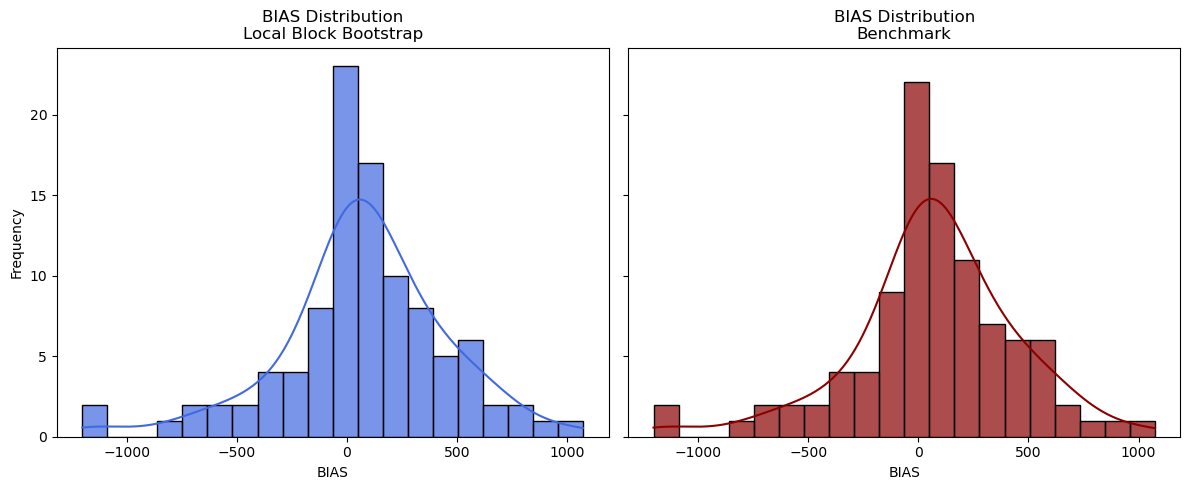

In [36]:
# Create side-by-side histograms with KDE
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Best parameters plot
sns.histplot(df_results.query( f"BLOCK_SIZE == {best_params[1]} & WINDOW_SIZE == {best_params[0]}")["BIAS"], bins=20, kde=True, color="royalblue", edgecolor="black", ax=axes[0], alpha=0.7)
axes[0].set_title(f"BIAS Distribution\nLocal Block Bootstrap")
axes[0].set_xlabel("BIAS")
axes[0].set_ylabel("Frequency")

# Benchmark plot
sns.histplot(df_results.query("BLOCK_SIZE == 1 & WINDOW_SIZE == 0")["BIAS"], bins=20, kde=True, color="darkred", edgecolor="black", ax=axes[1], alpha=0.7)
axes[1].set_title("BIAS Distribution\nBenchmark")
axes[1].set_xlabel("BIAS")
axes[1].set_ylabel("")  # No duplicate ylabel

# Adjust layout
plt.tight_layout()
plt.show()

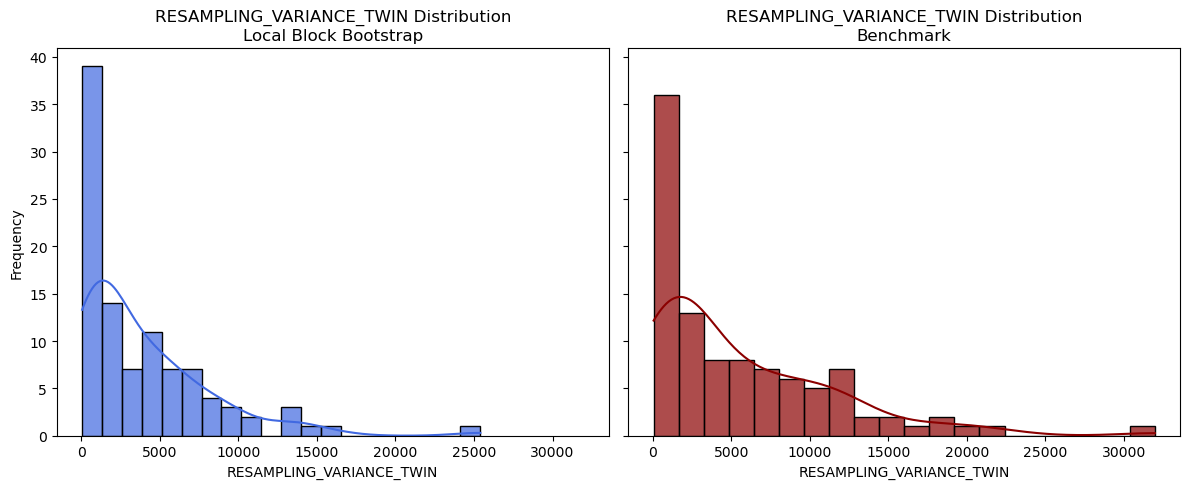

In [37]:
# Create side-by-side histograms with KDE
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Best parameters plot
sns.histplot(df_results.query( f"BLOCK_SIZE == {best_params[1]} & WINDOW_SIZE == {best_params[0]}")["RESAMPLING_VARIANCE_TWIN"], bins=20, kde=True, color="royalblue", edgecolor="black", ax=axes[0], alpha=0.7)
axes[0].set_title(f"RESAMPLING_VARIANCE_TWIN Distribution\nLocal Block Bootstrap")
axes[0].set_xlabel("RESAMPLING_VARIANCE_TWIN")
axes[0].set_ylabel("Frequency")

# Benchmark plot
sns.histplot(df_results.query("BLOCK_SIZE == 1 & WINDOW_SIZE == 0")["RESAMPLING_VARIANCE_TWIN"], bins=20, kde=True, color="darkred", edgecolor="black", ax=axes[1], alpha=0.7)
axes[1].set_title("RESAMPLING_VARIANCE_TWIN Distribution\nBenchmark")
axes[1].set_xlabel("RESAMPLING_VARIANCE_TWIN")
axes[1].set_ylabel("")  # No duplicate ylabel

# Adjust layout
plt.tight_layout()
plt.show()

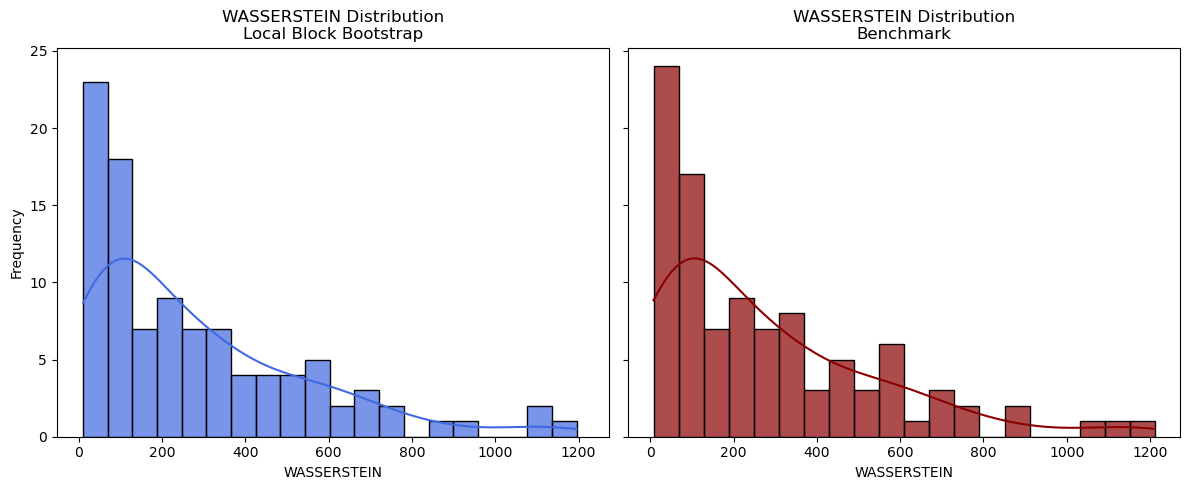

In [38]:
# Create side-by-side histograms with KDE
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Best parameters plot
sns.histplot(df_results.query( f"BLOCK_SIZE == {best_params[1]} & WINDOW_SIZE == {best_params[0]}")["WASSERSTEIN"], bins=20, kde=True, color="royalblue", edgecolor="black", ax=axes[0], alpha=0.7)
axes[0].set_title(f"WASSERSTEIN Distribution\nLocal Block Bootstrap")
axes[0].set_xlabel("WASSERSTEIN")
axes[0].set_ylabel("Frequency")

# Benchmark plot
sns.histplot(df_results.query("BLOCK_SIZE == 1 & WINDOW_SIZE == 0")["WASSERSTEIN"], bins=20, kde=True, color="darkred", edgecolor="black", ax=axes[1], alpha=0.7)
axes[1].set_title("WASSERSTEIN Distribution\nBenchmark")
axes[1].set_xlabel("WASSERSTEIN")
axes[1].set_ylabel("")  # No duplicate ylabel

# Adjust layout
plt.tight_layout()
plt.show()

In [39]:
# Summary Statistics: Median
median_results = df_results.groupby(["WINDOW_SIZE", "BLOCK_SIZE"])[["BIAS", "RESAMPLING_VARIANCE_TWIN", "WASSERSTEIN"]].median().reset_index()

# Summary Statistics: Mean
mean_results = df_results.groupby(["WINDOW_SIZE", "BLOCK_SIZE"])[["BIAS", "RESAMPLING_VARIANCE_TWIN", "WASSERSTEIN"]].mean().reset_index()

# Display results
display("Median Results:", median_results)
display("Mean Results:", mean_results)


'Median Results:'

,WINDOW_SIZE,BLOCK_SIZE,BIAS,RESAMPLING_VARIANCE_TWIN,WASSERSTEIN
0,0,1,56.680677,3354.570937,212.596750
1,1,1,58.079992,2267.339032,217.024368


'Mean Results:'

,WINDOW_SIZE,BLOCK_SIZE,BIAS,RESAMPLING_VARIANCE_TWIN,WASSERSTEIN
0,0,1,69.862765,5612.107820,280.755553
1,1,1,70.962431,3929.328365,282.424826


Conclusion:
- bootstrap method mainly influences the variance
- lowest variance is achieved via Sequential Panel Sampling

# Optimal Twin Size
- Trade off: few twins means having only the most similar products but also increases chance to miss out on variation

In [40]:
input_data_list = [InputData("ANSPRACHE_MARKETING_IMPUTED", max_twin_num = t, kernel_size = 1, verbose = False) for t in range(1, 11)]

results_twin_parameter  = []
for data in tqdm(input_data_list):
    for test_item_key in data.TestData.keys():
        summary_dict = Evaluation.run_lbb(data.TwinData[test_item_key], data.TestData[test_item_key], test_item_key, *best_params)
        summary_dict["MAX_TWIN_NUM"] = data.max_twin_num
        results_twin_parameter.append(summary_dict)

df_results_twin_parameter = pd.DataFrame(results_twin_parameter)
df_results_twin_parameter.to_csv("results/twin_parameter_results.csv", index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

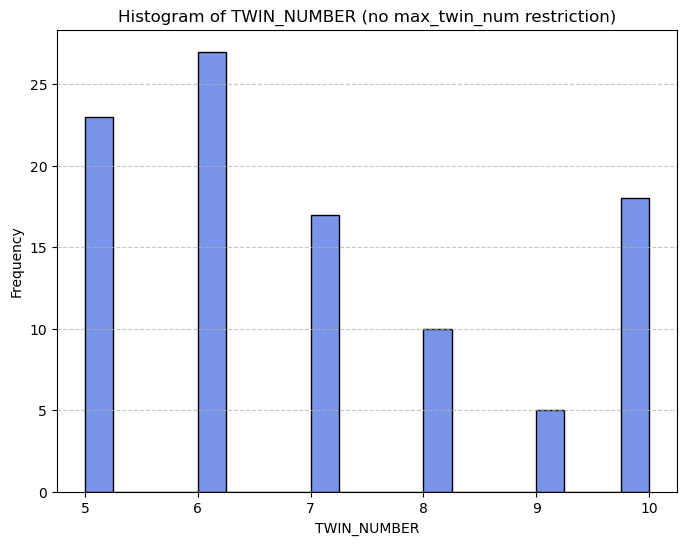

In [41]:
#group size for each twin number is unbalanced
plt.figure(figsize=(8, 6))
sns.histplot(df_results_twin_parameter.query("MAX_TWIN_NUM == 10")["TWIN_NUMBER"], bins=20, color="royalblue", edgecolor="black", alpha=0.7)
plt.xlabel("TWIN_NUMBER")
plt.ylabel("Frequency")
plt.title("Histogram of TWIN_NUMBER (no max_twin_num restriction)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [42]:
median_results = df_results_twin_parameter.groupby("MAX_TWIN_NUM")[["BIAS", "RESAMPLING_VARIANCE_TWIN", "WASSERSTEIN"]].median().reset_index()
display(median_results)

,MAX_TWIN_NUM,BIAS,RESAMPLING_VARIANCE_TWIN,WASSERSTEIN
0,1,98.879807,373.118591,251.344193
1,2,98.753004,805.227382,271.179051
2,3,108.529798,1321.197076,230.022760
3,4,107.038342,1523.223730,190.290989
4,5,91.921884,1401.203036,189.370252
5,6,103.761894,2196.510481,271.949654
6,7,62.545187,2180.739283,291.417165
7,8,62.094304,2203.966750,292.127238
8,9,51.034602,2211.599304,292.062969
9,10,77.401217,2250.718002,292.466911


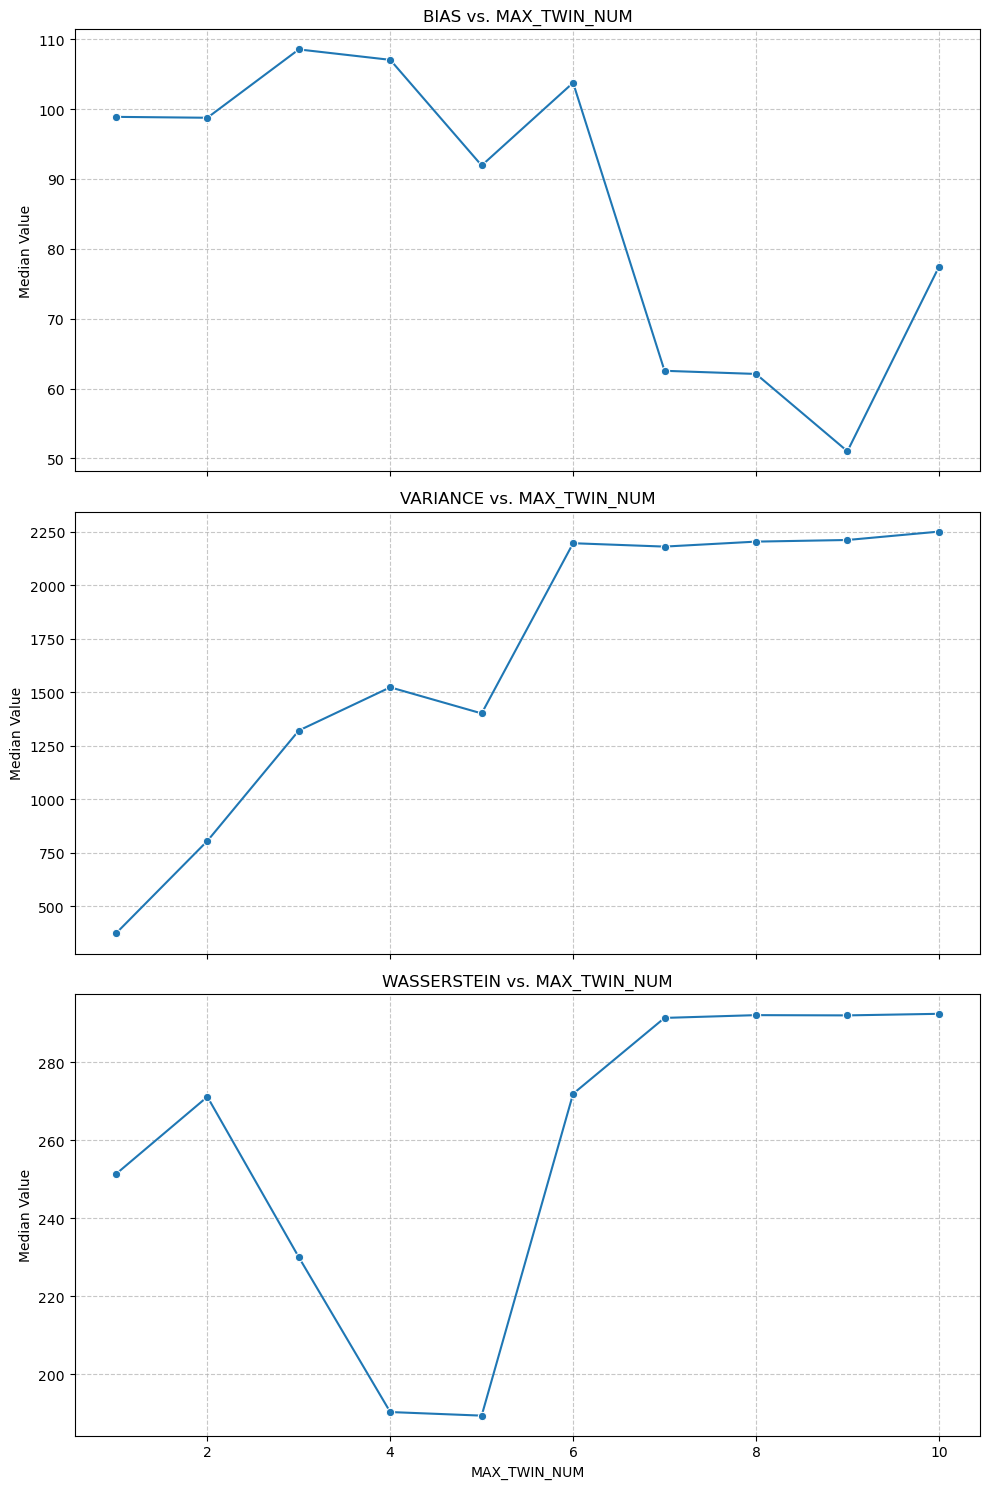

In [43]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# Define metrics and titles
metrics = ["BIAS", "RESAMPLING_VARIANCE_TWIN", "WASSERSTEIN"]
titles = ["BIAS vs. MAX_TWIN_NUM", "VARIANCE vs. MAX_TWIN_NUM", "WASSERSTEIN vs. MAX_TWIN_NUM"]

# Plot each metric separately
for i, metric in enumerate(metrics):
    sns.lineplot(data=median_results, x="MAX_TWIN_NUM", y=metric, marker="o", ax=axes[i])
    axes[i].set_title(titles[i])
    axes[i].set_ylabel("Median Value")
    axes[i].grid(True, linestyle="--", alpha=0.7)

# Set x-axis label for the last subplot
axes[-1].set_xlabel("MAX_TWIN_NUM")

# Adjust layout
plt.tight_layout()
plt.show()


### Fazit
- Variance goes up with increasing twin number
- Bias goes down with increasing twin number
- optimal wasserstein is in the center
- Is the influence of Variance and Bias equaly considered? bc of the scale differences it might not be totally fair?
- Ergebnisse sind erklärbar mit der approximation der Wasserstein distance 2nd order bei univariaten gausverteilungen

# Error Analysis
- How can we deal with the slight bias in our result?
- Identifying and analysing outlier items -> 3 Error types: twins way to high, twins way to low, different seasonality curves

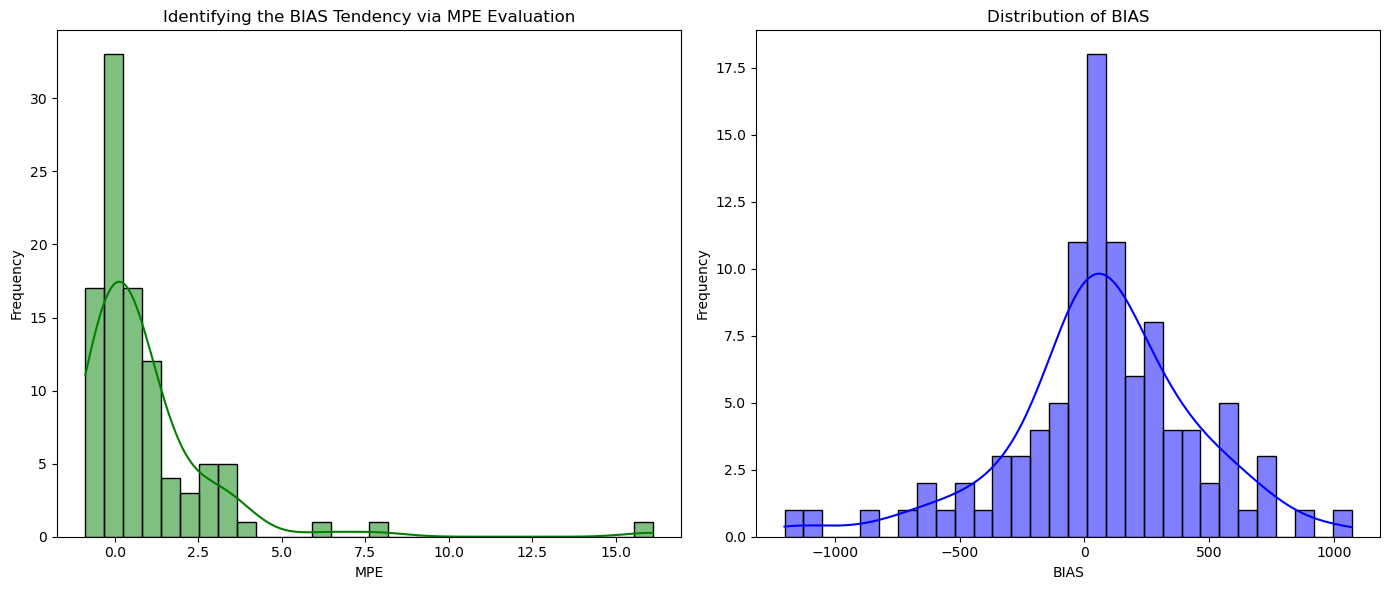

In [44]:
#note: mape is not symmetric!
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: LBB_MPE histogram
sns.histplot(df_results.query("WINDOW_SIZE != 0")["MPE"], bins=30, kde=True, color="green", ax=axes[0])
axes[0].set_xlabel("MPE")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Identifying the BIAS Tendency via MPE Evaluation")

# Second subplot: BIAS histogram
sns.histplot(df_results.query("WINDOW_SIZE != 0")["BIAS"], bins=30, kde=True, color="blue", ax=axes[1])
axes[1].set_xlabel("BIAS")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of BIAS")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
#wenn man range kennt -> null sollte mitte des bins sein, oder bin genau an der grenze -> sich dynamisch ändern bei neuem input

In [45]:
df_grid_results.query("WINDOW_SIZE == 0").groupby("TEST_ITEM_COMMUNICATIONKEY").median().sort_values("MAPE", ascending=True).reset_index()[["TEST_ITEM_COMMUNICATIONKEY", "MAPE", "MPE"]].head(30)
#Hauptfehlerquellen:
# Twins haben deutlich höhere Ansprache als der Testartikel
# Saisonkurven passen nicht
# Twins haben deutlich niedrigere Ansprache als der Testartikel

,TEST_ITEM_COMMUNICATIONKEY,MAPE,MPE
0,850575936,0.077929,0.008075
1,1088115601,0.089531,0.059839
2,811408901,0.091625,-0.071774
3,850562202,0.091718,-0.057703
4,1594262232,0.093030,0.040943
5,1085391770,0.098036,-0.016382
6,868192553,0.114361,-0.060933
7,869458445,0.114369,0.093657
8,811405342,0.115531,0.091269
9,1594271549,0.117835,-0.032698


# Experiments

- Apply smoothing function on input time series, Idee: summer verändert sich nicht, risiko peaks zu samplen geht runter
-> ist vielleicht eine ganz glatte serie besser geeignet, um blöcke zu samplen -> dann ist der input weniger random
- Ansprache Marketing Imputed -> nahezu keine Auswirkung, dazu keine Verbesserung
- Influence of number of twins
- Change of observation period, change of product group
- Einfluss von NAs auf den Fehler -> quasi keine NAs mehr, wenn wir bei FirstSoldout strikt cutten
- Einfluss von Soldout auf den Fehler


# Normality test
- clt is defined for iid data
- distributions moments must be finite?
- tune number of iteration until distribution is normal -> helps simplify methods of robust optimization

In [46]:
samples = Resampling.lb_bootstrap(input_data.TestData[804245827], 14, 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
ax1.hist(samples, bins=50, density=True, alpha=0.6, color='grey', edgecolor='black', label='Bootstrap PDF')
ax1.set_title('Histogram of Bootstrapped Values')
ax1.set_xlabel('Value')
ax1.set_ylabel('Density')

# Remove top and right spines for the histogram
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Calculate the normal PDF
x = np.linspace(min(samples), max(samples), 100)
normal_pdf = stats.norm.pdf(x, loc=np.mean(samples), scale=np.sqrt(np.var(samples, ddof = 1)))

# Plot the normal PDF
ax1.plot(x, normal_pdf, label='Normal PDF', color='black', linestyle='-')

# Plot the empirical CDF
data_sorted = np.sort(samples)
# Calculate the ECDF values
ecdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
ax2.plot(data_sorted, ecdf, marker='o', linestyle='none', color='grey', label='Bootstrap CDF')

# Remove top and right spines for the CDF
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Calculate the normal CDF
normal_cdf = stats.norm.cdf(x, loc=np.mean(samples), scale=np.sqrt(np.var(samples, ddof = 1)))

# Plot the normal CDF
ax2.plot(x, normal_cdf, label='Normal CDF', color='black', linestyle='-')

ax2.set_title('Empirical CDF vs Normal CDF')
ax2.set_xlabel('Value')
ax2.set_ylabel('Cumulative Probability')

# Add legends
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.savefig('plots/bootstrap_joint_distribution.svg')
plt.show()


KeyError: 804245827

In [ ]:
#H0: the data is normally distributed
#define alpha level
alpha = 0.05

In [ ]:
#generate integer samples from normal distribution
norm_samples = np.random.normal(50, 25, 100000).astype(int)

In [ ]:
_, p_value = stats.normaltest(samples)
print(p_value)
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data appears to be normally distributed.")
else:
    print("Reject the null hypothesis: The data does NOT appear to be normally distributed.")

5.071147263410315e-08
Reject the null hypothesis: The data does NOT appear to be normally distributed.


In [ ]:
# Warning: for N > 5000, computed p-value may not be accurate.
_, p_value = stats.shapiro(samples)
print(p_value)
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data appears to be normally distributed.")
else:
    print("Reject the null hypothesis: The data does not appear to be normally distributed.")

5.705737762718961e-07
Reject the null hypothesis: The data does not appear to be normally distributed.
